In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

In [2]:
# Robust Estimation of means:
# Huber weight function

def Huber(ei, sigma, s, a = 1.345):
    w1 = 1/sigma ** 2
    w2 = 1/sigma ** 2 * (a / (np.abs(ei) / (sigma * s)))
    weights = np.where(np.abs(ei) <= a * sigma * s, w1, w2)
    return weights

# For robust estimation of mean:

def ZL_robust_mean(y_, dy_, max_iter=50, tol=1e-6):
    """Output:
    robust mean,
    s (a sqrt(reduced chi2-like scale factor), s^2 ~ reduced chi2)"""
    y = y_
    dy = dy_
    y_bar = np.average(y, weights=1/dy**2)
    s = 1.0
    for _ in range(max_iter):
        ei = y - y_bar
        w = Huber(ei, dy, s)
        y_bar_old = y_bar
        y_bar = np.sum(w * y) / np.sum(w)
        mad = np.median(np.abs(y - y_bar) / dy)
        s = 1.4826 * mad if mad > 0 else 1.0
        # tolerance check   
        if np.abs(y_bar - y_bar_old) < tol * (np.abs(y_bar_old) + 1e-12):
            break
    return y_bar, s

def bootstrap_ZL_robust_mean(y, dy, n_boot=10000, random_state=None):
    """Output:
    mean of bootstrap samples,
    std of bootstrap samples,
    all bootstrap samples
    """
    rng = np.random.default_rng(random_state)
    boot_means = np.empty(n_boot)
    n = len(y)
    for i in tqdm.tqdm(range(n_boot)):
        indices = rng.integers(0, n, n)
        y_sample = y[indices]
        dy_sample = dy[indices]
        boot_means[i] = ZL_robust_mean(y_sample, dy_sample)[0]
    return boot_means.mean(), boot_means.std(), boot_means

# Code for robust linear regression using IRLS and Huber weights

def irls_robust_linear(x, y, dy, max_iter=50, tol=1e-6):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    dy = np.asarray(dy, dtype=float)

    # Design matrix: y = a + b x
    A = np.vstack([np.ones_like(x), x]).T

    # Initial conditions
    n = len(y)
    s = 1.0
    w = np.ones(n) / dy**2

    def solve_wls(A, y, weights):
        W = np.sqrt(weights)
        Aw = A * W[:, None]
        yw = y * W
        theta, *_ = np.linalg.lstsq(Aw, yw, rcond=None)
        return theta

    # Initial least squares solution
    theta = solve_wls(A, y, w)

    for _ in range(max_iter):
        theta_old = theta.copy()
        s_old = s

        # 1. compute residuals
        y_fit = A @ theta
        r = y - y_fit

        # 2. update scale s using MAD of |r| / dy
        mad = np.median(np.abs(r) / dy)
        s = 1.4826 * mad if mad > 0 else 1.0

        # 3. update weights using YOUR huber function
        w = Huber(r, dy, s)

        # 4. solve weighted least squares
        theta = solve_wls(A, y, w)

        # 5. convergence test
        if np.linalg.norm(theta - theta_old) < tol * (np.linalg.norm(theta_old) + 1e-12) and \
           abs(s - s_old) < tol * (s_old + 1e-12):
            break
    beta0, beta1 = theta
    return beta0, beta1, s, w

def bootstrap_irls(x, y, dy, n_boot=10000, random_state=None):
    """
    Bootstrap IRLS over (x, y, dy) triplets.
    
    Returns:
        beta0_samples : array of intercepts
        beta1_samples : array of slopes
        s_samples : array of scale estimates
    """
    import numpy as np

    if random_state is not None:
        np.random.seed(random_state)

    x = np.asarray(x)
    y = np.asarray(y)
    dy = np.asarray(dy)

    n = len(x)

    beta0_samples = np.empty(n_boot)
    beta1_samples = np.empty(n_boot)
    s_samples = np.empty(n_boot)

    for i in tqdm.tqdm(range(n_boot)):
        # 1. Resample indices with replacement
        idx = np.random.randint(0, n, size=n)

        # 2. Resample triplets together
        xb = x[idx]
        yb = y[idx]
        dyb = dy[idx]

        # 3. Run IRLS on bootstrap sample
        beta0, beta1, s, _ = irls_robust_linear(xb, yb, dyb)

        # 4. Store results
        beta0_samples[i] = beta0
        beta1_samples[i] = beta1
        s_samples[i] = s

    return beta0_samples, beta1_samples, s_samples

In [3]:
df = pd.read_csv(r"C:\ACMEcode\ACMEanalysis\notebooks\systematics\robust\J=1_Rot_Col\data\0015.0685_0015.0686_0015.0687_0015.0688_0015.0689_.csv")

In [4]:
x_name = 'Charmander_AOM_Frequency'
y_name = 'omega_NE'
dy_name = 'uncertainty_omega_NE'

x_unit = 'MHz'

x = df[x_name]
y = df[y_name]
dy = df[dy_name]

In [5]:
beta0 , beta1, s, w= irls_robust_linear(x, y, dy)
w = w / np.max(w)  # normalize weights for plotting
beta0_samples, beta1_samples, s_samples = bootstrap_irls(x, y, dy, n_boot=10000, random_state=None)
se_beta0 = np.std(beta0_samples)
se_beta1 = np.std(beta1_samples)
print(f"Intercept: {beta0 * 1000000:.4f} ± {se_beta0 * 1000000:.4f} μrad/s")
print(f"Slope: {beta1 * 1000000:.4f} ± {se_beta1 * 1000000:.4f} μrad/s/"+f"{x_unit}")
print(f"Scale s: {s:.4f}")

100%|██████████| 10000/10000 [00:09<00:00, 1030.99it/s]

Intercept: 162.0932 ± 1479.9401 μrad/s
Slope: -11.2392 ± 21.2660 μrad/s/MHz
Scale s: 1.2391


Text(0, 0.5, 'omega_NE (μrad/s)')

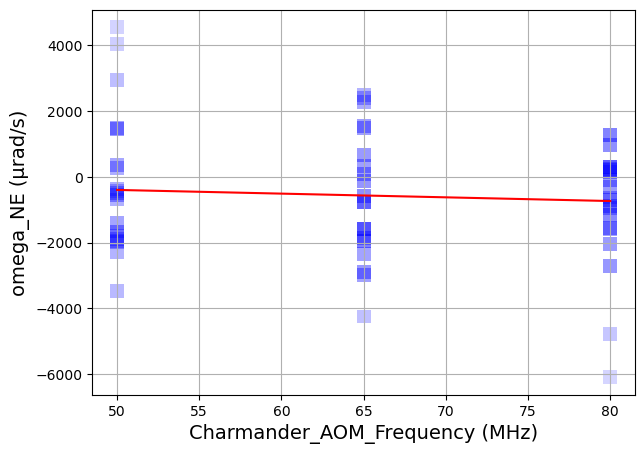

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
# error bar plot with horizontal caps on error bar
#ax.errorbar(x, y*1000000, yerr=dy*1000000, fmt='.', markersize = 0, capsize=3, label='Data with error bars')
ax.scatter(x, y*1000000, s=100, marker = 's',c='blue', alpha=w*0.5, edgecolors= 'none',label='Data points weighted by IRLS')
# plot best fit line
x_fit = np.linspace(np.min(x), np.max(x), 100)
y_fit = beta0 + beta1 * x_fit
ax.plot(x_fit, y_fit*1000000, 'r-', label='Robust Linear Fit')
ax.grid()
ax.set_xlabel(f"{x_name} ({x_unit})", fontsize=14)
ax.set_ylabel(f"{y_name} (μrad/s)", fontsize=14)